In [1]:
import torch
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

1.11.0+cu113


In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch_geometric.data import Data
import pickle

In [3]:
# attack_feature = np.array(np.load("attack_matrix.npz",allow_pickle=True)["arr_0"])
# normal_feature = np.array(np.load("normal_matrix.npz",allow_pickle=True)["arr_0"])

In [4]:
attack_feature = np.array(np.load("attack_temporal_embedding.npz",allow_pickle=True)["arr_0"])
normal_feature = np.array(np.load("normal_temporal_embedding.npz",allow_pickle=True)["arr_0"])

In [5]:
attack_feature.shape

(89978, 51, 6)

In [6]:
adjacentMatrix = np.load('adjacentMatrix.npz')
adjacentMatrix = np.array(np.load("adjacentMatrix.npz", allow_pickle=True)["arr_0"])

In [7]:
attack_tensor= torch.tensor(attack_feature)
normal_tensor = torch.tensor(normal_feature)

In [8]:
attack_tensor.shape

torch.Size([89978, 51, 6])

In [9]:
normal_tensor.shape

torch.Size([99354, 51, 6])

In [10]:
typeDict = {
    0:[0, 8, 17, 27, 38, 39, 40, 41, 47],
    1:[1, 18, 28 ],
    2:[2, 9, 19, 20, 21, 22 ],
    3:[3, 4, 10, 11, 12, 13, 14, 15, 23, 24, 29, 30, 31, 32, 42, 43, 48, 49, 50],
    4:[5, 6, 7, 25, 26, 34, 35, 36, 37 ],
    5:[16],
    6:[33],
    7:[44, 45, 46]
}

In [11]:
def get_sensor_type(val, dict_type):
    for sensor_type, sensor_list in dict_type.items():
        for sensor in sensor_list: 
            if val == sensor:
                return sensor_type

In [12]:
def get_index_of_adjacentMatrix(data):
    result = []
    i_index = []
    j_index = []
    for i,line in enumerate(data):
        for j,item in enumerate(line):
            if item != 0:
                i_index.append(i)
                j_index.append(j)
    result.append(i_index)
    result.append(j_index)
    return result

In [13]:
def create_spatio_temporal_embedding(typeDict,
                                         adjacentMatrix,
                                            embed_collections):
    
    all_embeds = []
    
    #get embed for a time segment
    for i in range(embed_collections.shape[0]):
        temp_embed = embed_collections[i]
        temp_embed = torch.squeeze(temp_embed)

        if i%10000==0:
            print("done", i, "th graph")
         
        #start making clusters and get mean embed
        ClusterDict = {}
        ClusterDict = dict.fromkeys(typeDict.keys(),[])
        for key,value in typeDict.items():
            for key_clust in ClusterDict.keys():
                if key_clust == key:
                    ClusterDict[key_clust] = temp_embed[value,:]
                    ClusterDict[key_clust] = torch.mean(ClusterDict[key_clust],0)
        
        #start calculating similarity between clusters
        Distance_Mat = np.zeros((len(ClusterDict), len(ClusterDict)))
        
        for key in ClusterDict.keys():
            for key_2 in ClusterDict.keys():
                Distance_Mat[key][key_2] = nn.CosineSimilarity(dim=0, eps=1e-8)(ClusterDict[key],ClusterDict[key_2])
        
        #start making weighted adj matrix
        WeightsOf_AdjMat = np.zeros((51,51))
        
        for i in range(WeightsOf_AdjMat.shape[0]):
            for j in range(WeightsOf_AdjMat.shape[1]):
                type_i = get_sensor_type(i, typeDict)
                type_j = get_sensor_type(j, typeDict)
                WeightsOf_AdjMat[i,j] = Distance_Mat[type_i, type_j]
                
        Weighted_AdjMat = np.multiply (WeightsOf_AdjMat, adjacentMatrix)
        
        x = torch.tensor(temp_embed,dtype=torch.float)
        edge_index = get_index_of_adjacentMatrix(Weighted_AdjMat) 
        edge_index = torch.tensor(edge_index,dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)
        all_embeds.append(data)

        
    return all_embeds

In [14]:
attack_embeddings = create_spatio_temporal_embedding(typeDict,
                                        adjacentMatrix, attack_tensor
                                        )

# with open("graph_attack.pkl","wb") as f:
#       pickle.dump(attack_embeddings,f)
        

normal_embeddings = create_spatio_temporal_embedding(typeDict,
                                        adjacentMatrix, normal_tensor
                                        )

# with open("graph_normal.pkl","wb") as f2:
#       pickle.dump(normal_embeddings,f2)



done 0 th graph


C:\Users\Raiyan\AppData\Local\Temp\ipykernel_8032\2401474895.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(temp_embed,dtype=torch.float)


done 10000 th graph
done 20000 th graph
done 30000 th graph
done 40000 th graph
done 50000 th graph
done 60000 th graph
done 70000 th graph
done 80000 th graph
done 0 th graph
done 10000 th graph
done 20000 th graph
done 30000 th graph
done 40000 th graph
done 50000 th graph
done 60000 th graph
done 70000 th graph
done 80000 th graph
done 90000 th graph


In [27]:
normal_embeddings[0]

Data(x=[51, 6], edge_index=[2, 58])

In [20]:
# np.savez_compressed("normal_spatio_temporal_embeds",normal_embeddings)
# np.savez_compressed("attack_spatio_temporal_embeds",attack_embeddings)

In [29]:
filename="normal_graph_in_pickle_spatial"
with open(filename, 'wb') as f:
    pickle.dump(normal_embeddings,f)

    
filename="attack_graph_in_pickle_spatio"
with open(filename, 'wb') as f:
    pickle.dump(attack_embeddings,f)

In [30]:
normal_embeddings[1]

Data(x=[51, 6], edge_index=[2, 58])

In [31]:
import os.path as osp
import argparse
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, GAE, VGAE
import pickle
import numpy as np
import time

In [32]:
print("start loading data!")
t0 = time.time()
normal_dataset = []
attack_dataset = []

with open("normal_graph_in_pickle_spatial","rb") as f:
    normal_dataset = pickle.load(f)    
with open("attack_graph_in_pickle_spatio","rb") as f:
    attack_dataset = pickle.load(f)
    
print("end load, cost time:",str(time.time()/1000))

start loading data!
end load, cost time: 1667827.8024715318


In [33]:
len(normal_dataset)

99354

In [34]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        # if args.model in ['GAE']:
        #     self.conv2 = GCNConv(2 * out_channels, out_channels)
        # elif args.model in ['VGAE']:
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logvar = GCNConv(
                2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        # if args.model in ['GAE']:
        #     return self.conv2(x, edge_index)
        # elif args.model in ['VGAE']:
        return self.conv_mu(x, edge_index), self.conv_logvar(x, edge_index)

In [35]:
channels = 16
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGAE(Encoder(6, channels)).to(dev)

In [36]:
print(model)

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(6, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logvar): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)


In [37]:
#x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

normal_loader = DataLoader(normal_dataset, batch_size=64, shuffle=False)
attack_loader = DataLoader(attack_dataset, batch_size=64, shuffle=False)


In [38]:
def train(data,data_index,epoch):
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.edge_index)
    loss = model.recon_loss(z, data.edge_index)
    # if args.model in ['VGAE']:
    loss = loss + (1 / data.num_nodes) * model.kl_loss()

    if data_index % 1000 == 0:
    	print("epoch:{:03d},batch:{:03d},loss:{:.4f}".format(epoch,data_index,loss))
    loss.backward()
    optimizer.step()

In [39]:
def test(data):
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.edge_index)
    return z

In [40]:
#train model 
for epoch in range(10):
    for i,data in enumerate(normal_loader):
        # data = np.squeeze(data)
        data = data.to(dev)
        train(data,i,epoch)
        
    for i,data in enumerate(attack_loader):
        data = data.to(dev)
        train(data,i,epoch)


epoch:000,batch:000,loss:8.2807
epoch:000,batch:1000,loss:1.3813
epoch:000,batch:000,loss:1.3795
epoch:000,batch:1000,loss:1.3825
epoch:001,batch:000,loss:1.3799
epoch:001,batch:1000,loss:1.3824
epoch:001,batch:000,loss:1.3735
epoch:001,batch:1000,loss:1.3704
epoch:002,batch:000,loss:1.3430
epoch:002,batch:1000,loss:1.3671
epoch:002,batch:000,loss:1.3474
epoch:002,batch:1000,loss:1.3489
epoch:003,batch:000,loss:1.3167
epoch:003,batch:1000,loss:1.3558
epoch:003,batch:000,loss:1.3416
epoch:003,batch:1000,loss:1.3372
epoch:004,batch:000,loss:1.3223
epoch:004,batch:1000,loss:1.3505
epoch:004,batch:000,loss:1.3325
epoch:004,batch:1000,loss:1.3379
epoch:005,batch:000,loss:1.3285
epoch:005,batch:1000,loss:1.3490
epoch:005,batch:000,loss:1.3431
epoch:005,batch:1000,loss:1.3316
epoch:006,batch:000,loss:1.3172
epoch:006,batch:1000,loss:1.3494
epoch:006,batch:000,loss:1.3282
epoch:006,batch:1000,loss:1.3374
epoch:007,batch:000,loss:1.3234
epoch:007,batch:1000,loss:1.3562
epoch:007,batch:000,loss:

In [41]:
#get normal spatio temporal embedding vector

normal_loader_final = DataLoader(normal_dataset, batch_size=1, shuffle=False)
attack_loader_final = DataLoader(attack_dataset, batch_size=1, shuffle=False)

normal_spatio_temporal_embedding = []
for data in normal_loader_final:
    data = data.to(dev)
    temp = test(data)
    normal_spatio_temporal_embedding.append(temp)
    

#get attack spatio temporal embedding vector
attack_spatio_temporal_embedding = []
for data in attack_loader_final:
    data = data.to(dev)
    temp = test(data)
    attack_spatio_temporal_embedding.append(temp)   


In [42]:
#go from list of tensors to list of matrix
#to compress and save easily

normal_spatio_temporal_embedding_matrix=[]

for item in normal_spatio_temporal_embedding:
    item = item.to("cpu")
    item = item.numpy()
    normal_spatio_temporal_embedding_matrix.append(item)

In [43]:
normal_features = np.asarray(normal_spatio_temporal_embedding_matrix)
normal_features.shape

(99354, 51, 16)

In [44]:
attack_spatio_temporal_embedding_matrix=[]

for item in attack_spatio_temporal_embedding:
    item = item.to("cpu")
    item = item.numpy()
    attack_spatio_temporal_embedding_matrix.append(item)

In [45]:
attack_features = np.asarray(attack_spatio_temporal_embedding_matrix)

In [46]:
attack_features.shape

(89978, 51, 16)

In [47]:
np.savez_compressed("normal_spatio_temporal_embeddings",normal_features)
np.savez_compressed("attack_spatio_temporal_embeddings",attack_features)

In [48]:
###trying to visualize using sklearn seaborn and tsne

import seaborn as sns
from sklearn import datasets
from sklearn import manifold

In [49]:
p = np.mean(normal_features[1], axis=0)

In [50]:
attack_temp_feature = np.array(np.load("attack_spatio_temporal_embeddings.npz",allow_pickle=True)["arr_0"])
normal_temp_feature = np.array(np.load("normal_spatio_temporal_embeddings.npz",allow_pickle=True)["arr_0"])

In [51]:
normal_mean_features=np.mean(normal_temp_feature, axis=1)

# for i in range(normal_temp_feature.shape[0]):
#     temp = np.mean(normal_temp_feature[i], axis=0)
#     normal_mean_features.append(temp)

In [52]:
# normal_mean_features = np.asarray(normal_mean_features)

In [53]:
normal_mean_features.shape

(99354, 16)

In [54]:
attack_mean_features=np.mean(attack_temp_feature, axis=1)

# for i in range(attack_temp_feature.shape[0]):
#     temp = np.mean(attack_temp_feature[i], axis=0)
#     attack_mean_features.append(temp)

In [55]:
# attack_mean_features = np.asarray(attack_mean_features)
# attack_mean_features.shape

In [56]:
# dimensionality reduction using t-SNE
tsne = manifold.TSNE(n_components=2, random_state=42)

# fit and transform
normal_tsne = tsne.fit_transform(normal_mean_features)

# transformed_data is a 2D numpy array of shape (99353, 3)

C:\Users\Raiyan\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Raiyan\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [57]:
normal_tsne.shape

(99354, 2)

In [58]:
normal_tsne[0]

array([-51.097355,  12.165639], dtype=float32)

In [59]:
import pandas as pd
normal_df = pd.DataFrame(columns=['CP1', 'CP2'],
                       data=np.row_stack(normal_tsne))
normal_df.head()

,CP1,CP2
0,-51.097355,12.165639
1,-51.101841,12.149138
2,-51.103657,12.142260
3,-51.104458,12.139239
4,-51.106541,12.131427


In [60]:
tsne = manifold.TSNE(n_components=2, random_state=42)

# fit and transform
attack_tsne = tsne.fit_transform(attack_mean_features)

attack_tsne.shape

C:\Users\Raiyan\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Raiyan\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(89978, 2)

In [61]:
attack_target_label = np.array(np.load('newlabel_swat.npz')['arr_0'])

In [62]:
attack_target_label = np.reshape(attack_target_label, (attack_target_label.shape[0],1))

In [63]:
attack_tsne_with_target = np.append(attack_tsne, attack_target_label, 1)
attack_tsne_with_target.shape

(89978, 3)

In [64]:
attack_df = pd.DataFrame(columns=['CP1', 'CP2', 'target'],
                       data=np.row_stack(attack_tsne_with_target))

attack_df.loc[:, 'target'] = attack_df.target.astype(int)
attack_df.head()

,CP1,CP2,target
0,36.661263,14.684780,0
1,30.767288,19.849092,0
2,29.848692,20.427111,0
3,28.475668,21.232000,0
4,30.125591,20.116507,0


In [65]:
attack_map = {0:'Not attack',
               1: 'Attack'}# map targets to actual clothes for plotting
attack_df.loc[:, 'target'] = attack_df.target.map(attack_map)

<AxesSubplot:>

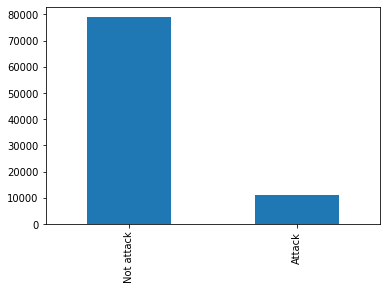

In [66]:
attack_df.target.value_counts().plot(kind='bar')

In [67]:
attack_new_df = attack_df.groupby('target').sample(n=4000)

<AxesSubplot:>

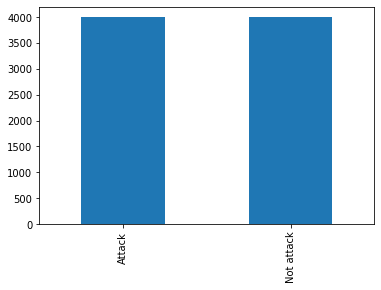

In [68]:
attack_new_df.target.value_counts().plot(kind='bar')

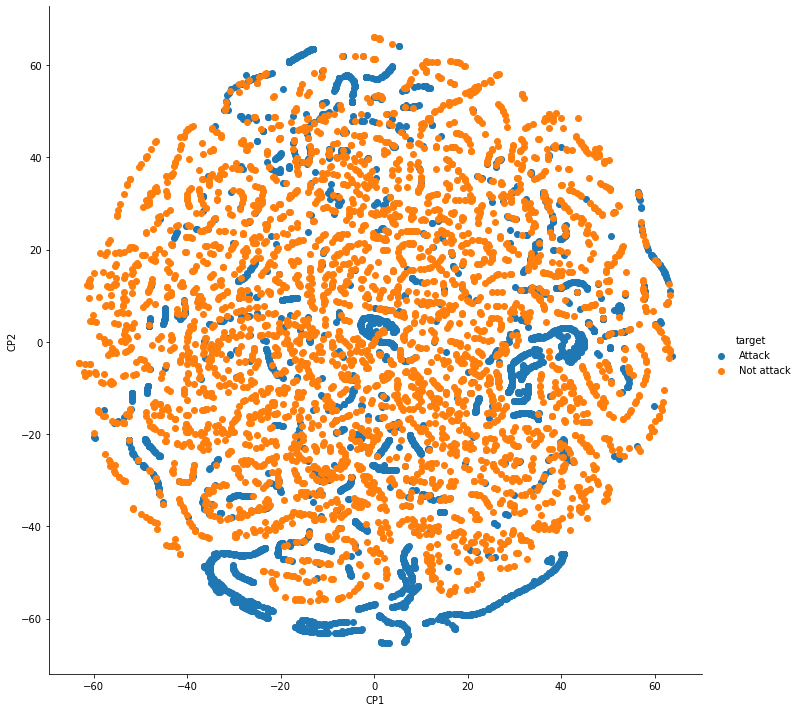

In [69]:
import matplotlib.pyplot as plt

grid = sns.FacetGrid(attack_new_df, hue="target", height=10)
grid.map(plt.scatter, 'CP1', 'CP2').add_legend()

In [ ]:
# pip install plotly

In [ ]:
import plotly.express as px

In [ ]:
x = attack_new_df['CP1']
y = attack_new_df['CP2']
# z = attack_new_df['CP3']
fig = px.scatter(attack_new_df, x, y,
              color= attack_new_df['target'])
fig.show()

In [ ]:
data = pd.read_hdf("attack.h5")
attack_label = data['isAttack'].to_numpy()

In [ ]:
attack_label.shape[0]

In [ ]:
attack_label

In [ ]:
attack_target_label = []
flag = 0

for i in range(0,attack_label.shape[0]-1,5):
#     first_index = i
#     last_index = i+25
#     print(first_index, last_index)
    temp_list = (attack_label[i:i+25]) 
    for item in temp_list:
        if item == 1:
            flag = 1
    attack_target_label.append(flag)
    flag = 0

In [ ]:
len(attack_target_label)

In [ ]:
attack_target_label = np.asarray(attack_target_label)

In [ ]:
attack_target_label = attack_target_label[:, np.newaxis]

In [ ]:
attack_target_label.shape

In [ ]:
c.shape

In [ ]:
attack_tsne.shape

In [ ]:
type(attack_features)

In [ ]:
attack_features.shape

In [ ]:
results = np.where(attack_target_label==1)

In [ ]:
results

In [ ]:
p = attack_mean_features[89030]
p = torch.from_numpy(p)
p.shape

In [ ]:
p

In [ ]:
q = attack_mean_features[89189]
q = torch.from_numpy(q)
q.shape

In [ ]:
opps = nn.CosineSimilarity(dim=0, eps=1e-8)(p,q)
opps

In [ ]:
dist_opps = torch.cdist(p.reshape(1,16), q.reshape(1,16), p=15)
dist_opps

In [ ]:
m= attack_mean_features[89036]
m= torch.from_numpy(m)

In [ ]:
sim = nn.CosineSimilarity(dim=0, eps=1e-8)(p,m)

In [ ]:
sim

In [ ]:
another_opps = nn.CosineSimilarity(dim=0, eps=1e-8)(q,m)
another_opps

dist_opps = torch.cdist(m.reshape(1,16), q.reshape(1,16))
dist_opps

In [ ]:
dist_sim = torch.cdist(p.reshape(1,16), m.reshape(1,16), p= 15)
dist_sim

In [ ]:
tuple([5])